# Analysis Tutorial

This tutorial demonstrates how to analyze and interpret the outputs from Connectomemapper 3. In particular it will:

- Get the list of connectome files with [`pybids`](https://pypi.org/project/pybids/)
- Read the .tsv connectome files with [`networkx`](https://pypi.org/project/networkx/)
- Visualize with the plot functions of [`nilearn`](https://pypi.org/project/nilearn/) ([docs](https://nilearn.github.io/stable/index.html))
- Analyze with [`bctpy (Brain Connectivity Toolbox)`](https://pypi.org/project/bctpy/)

In [28]:
import nilearn
import os
import pygsp
import networkx as nx
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datalad.api as dl
import scipy.io as sio
from bids import BIDSLayout
from nilearn import plotting

## Loading and Plotting Adjacency Matrices

For demonstration, we are going to use an example dataset from [Open Neuro](https://openneuro.org/datasets/ds003505/versions/1.0.2) that already contains output from Connectomemapper.

In [29]:
# download example dataset with datalad
# uncomment next line once the new dataset is up
#vepcon_data = dl.install(path=os.path.join("..", "..", "example_data"),
#                         source="https://github.com/OpenNeuroDatasets/ds003505.git")

As the dataset is in [BIDS](https://bids.neuroimaging.io/), we can use [Pybids](https://bids-standard.github.io/pybids/) to help us load the data.

In [30]:
#layout = BIDSLayout(vepcon_data.path)
# add derivative folder containing the connectivity matrices
#layout.add_derivatives(os.path.join(vepcon_data.path, "derivatives", "cmp-v3.0.0-beta-RC1"))

In [31]:
#layout = BIDSLayout(vepcon_data.path)
path = os.path.join("/home", "localadmin", "data", "ds003505-sample")
layout = BIDSLayout(path)
# add derivative folder containing the connectivity matrices
#layout.add_derivatives(os.path.join(vepcon_data.path, "derivatives", "cmp-v3.0.0-beta-RC1"))
layout.add_derivatives(os.path.join(path, "derivatives", "cmp-v3.0.1"))

Now we can easily query for the filenames of the files we are interested in using `layout.get`. We will ask for the connectivity matrix of subject 01, scale 3, in tsv format. It will be returned as a list of file paths (in this case containing just one element).

In [32]:
conn_tsv_scale3 = layout.get(subject='01', extension='tsv',
                             suffix='connectivity', return_type='filename',
                             res='scale3')
conn_tsv_scale3

['/home/localadmin/data/ds003505-sample/derivatives/cmp-v3.0.1/sub-01/dwi/sub-01_atlas-L2018_res-scale3_conndata-network_connectivity.tsv']

We can then use [Pandas](https://pandas.pydata.org/) to read the file and display it as a table.

In [33]:
#edges = pd.read_csv(con_files[0], delimiter="\t")
edges = pd.read_csv(conn_tsv_scale3[0], delimiter="\t")
edges.head()

,source,target,number_of_fibers,fiber_length_mean,fiber_length_median,fiber_length_std,fiber_proportion,fiber_density,normalized_fiber_density,FA_mean,FA_std,FA_median,ADC_mean,ADC_std,ADC_median
0,1,1,578,6.577855,6.000000,2.086783,0.139558,0.024422,0.067457,0.190930,0.076994,0.176868,0.000787,0.000086,0.000775
1,1,3,254,9.507873,8.000008,4.339883,0.061328,0.007618,0.021041,0.184138,0.079206,0.172769,0.000801,0.000073,0.000799
2,1,9,101,10.198020,8.500000,4.645918,0.024386,0.003385,0.009351,0.258646,0.100590,0.252733,0.000780,0.000101,0.000756
3,1,2,98,7.704082,6.999998,2.756104,0.023662,0.003056,0.008441,0.247499,0.109299,0.247938,0.000815,0.000060,0.000812
4,1,113,59,10.203390,9.500001,3.235289,0.014245,0.002269,0.006268,0.243196,0.059146,0.241589,0.000858,0.000121,0.000855


Using [Networkx](https://networkx.org/documentation/stable/index.html), we can convert this table to a network graph. From that, we can convert individual measures to a [Numpy](https://numpy.org/) matrix. The matrix format is especially useful, as it allows us to plot the edge weights easily.

In [34]:
G = nx.from_pandas_edgelist(edges, edge_attr=True)
A_fiber_density = nx.to_numpy_matrix(G, weight="fiber_density")

Let's plot some of those adjacency matrices using [Matplotlib](https://matplotlib.org/) and [Seaborn](http://seaborn.pydata.org/index.html):

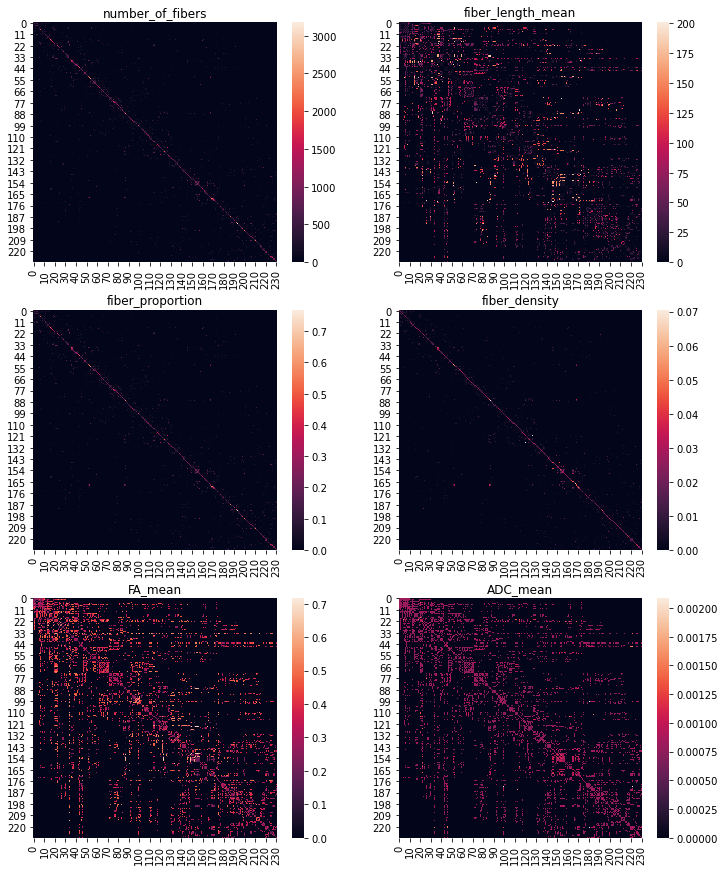

In [35]:
cols_to_plot = ["number_of_fibers", "fiber_length_mean",
                "fiber_proportion", "fiber_density",
                "FA_mean", "ADC_mean"]

fig, axs = plt.subplots(3,2, figsize=(12,15))
axs = axs.flatten()
for c, ax in zip(cols_to_plot, axs):
    A = nx.to_numpy_matrix(G, weight=c)
    sns.heatmap(A, ax=ax)
    ax.set_title(c)

Alternatively, we can also load the matrices in network format, by reading the gpickle files using Networkx:

In [36]:
conn_gpickle_scale3 = layout.get(subject='01', extension='gpickle',
                                 suffix='connectivity',
                                 return_type='filename',
                                 res='scale3')
G = nx.read_gpickle(conn_gpickle_scale3[0])  # same format as with tsv

...or load the .mat files with [Scipy](https://scipy.org/):

In [37]:
conn_mat_scale3 = layout.get(subject='01', extension='mat',
                             suffix='connectivity', return_type='filename',
                             res='scale3')
A_mat = sio.loadmat(conn_mat_scale3[0])

The adjacency matrices here can be accessed like this:

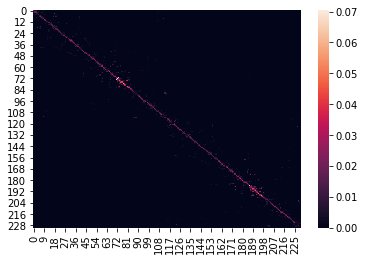

In [38]:
sns.heatmap(A_mat["sc"]["fiber_density"][0][0])
plt.show()

## Graph Signal Processing with Structural Connectivity

The package [PyGSP](https://pygsp.readthedocs.io/en/stable/index.html) offers a range of graph signal processing tools we can use on our structural connectivity data. In particular, we can do an eigendecomposition of the [graph Laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix) to get the Fourier basis - the connectome harmonics.

In [39]:
np.fill_diagonal(A_fiber_density, 0)  # PyGSP does not support self-loops
G_fd = pygsp.graphs.Graph(A_fiber_density)  # PyGSP graph
G_fd.compute_fourier_basis()  # compute connectome harmonics

The harmonics have the same dimensions as our original adjacency matrix.

In [40]:
G_fd.U.shape

(231, 231)

Each column contains one basis vector. [Nilearn](https://nilearn.github.io/stable/index.html) offers a quick and easy way to plot them.

ValueError: Shape mismatch between 'adjacency_matrix' and 'node_coords''adjacency_matrix' shape is (231, 231), 'node_coords' shape is (234, 3)

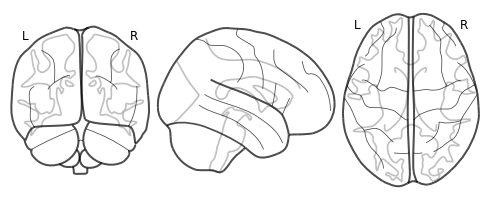

In [41]:
# UPDATE PATH ONCE AVAILABLE
path_hcp = "/home/localadmin/Desktop/tutorial/derivatives/cmp/sub-100307/anat"
parcellation_path = os.path.join(path_hcp, "sub-100307_atlas-L2008_res-scale3_dseg.nii.gz")
coords, labels = plotting.find_parcellation_cut_coords(parcellation_path, return_label_names=True)

plotting.plot_connectome(G_fd.U, coords)

A prettier version is to plot just the cortex harmonics on a brain surface:

In [42]:
def plot_surface_ctx(roi_values, scale, cmp_dir, cmap="Spectral", save_fig=False,
                     output_dir="./", fmt="png"):
    # surface mesh
    fsaverage = datasets.fetch_surf_fsaverage(mesh="fsaverage")
    label_dir = cmp_dir+"/cmtklib/data/parcellation/lausanne2018"
    scale = scale

    # file paths to the annot files
    annots = [os.path.join(label_dir, f'rh.lausanne2008.scale{scale}.annot'),
              os.path.join(label_dir, f'lh.lausanne2008.scale{scale}.annot')]

    # read annot files
    annot_right = nb.freesurfer.read_annot(annots[0])
    annot_left = nb.freesurfer.read_annot(annots[1])

    # create vector to store intensity values (one value per vertex)
    roi_vect_right = np.zeros_like(annot_right[0], dtype=float)
    roi_vect_left = np.zeros_like(annot_left[0], dtype=float)

    # convert labels to strings, labels are the same as 2018 is symmetric
    labels = [str(elem, 'utf-8') for elem in annot_right[2]]

    # create roi vectors
    for i in range(len(labels[1:])):  # skip 'unknown'
        ids_roi = np.where(annot_right[0] == i+1)[0]
        roi_vect_right[ids_roi] = roi_values[i]

    for i in range(len(labels[1:])):  # skip 'unknown'
        ids_roi = np.where(annot_left[0] == i+1)[0]
        roi_vect_left[ids_roi] = roi_values[i+len(labels)-1]

    # get min and max values
    vmin = min(roi_values)
    vmax = max(roi_values)

    # center around 0
    max_val = max([abs(vmin), vmax])
    vmax = max_val
    vmin = -max_val

    # plot
    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_right'], roi_map=roi_vect_right,
                           hemi='right', view='lateral',
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_right_lateral.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=roi_vect_left,
                           hemi='left', view='lateral',
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_left_lateral.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_right'], roi_map=roi_vect_right,
                           hemi='right', view='medial',
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_right_medial.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=roi_vect_left,
                           hemi='left', view='medial',
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_left_medial.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_right'], roi_map=roi_vect_right,
                           hemi='right', view='ventral',
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_right_ventral.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=roi_vect_left,
                           hemi='left', view='ventral',
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_left_ventral.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_right'], roi_map=roi_vect_right,
                           hemi='right', view='dorsal',
                           bg_map=fsaverage['sulc_right'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_right_dorsal.{fmt}')

    fig, axs = plt.subplots(subplot_kw={'projection': '3d'})
    plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=roi_vect_left,
                           hemi='left', view='dorsal',
                           bg_map=fsaverage['sulc_left'], bg_on_data=True,
                           darkness=.5, cmap=cmap,
                           vmin=vmin, vmax=vmax,
                           figure=fig)
    if save_fig:
        fig.savefig(f'{output_dir}/scale{scale}_left_dorsal.{fmt}')